This notebook tries to search for optimal fixed policies (e.g. constant mortality) that maximize the objective (i.e. expected net reward). Here I try [scikit-optimize](https://scikit-optimize.github.io/stable/index.html) routines which are designed for noisy functions and compare to a brute-force parallel grid search.  

In [1]:
%pip install -e ..

Obtaining file:///home/rstudio/rl4fisheries
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for rl4fisheries (pyproject.toml) ... done
  Created wheel for rl4fisheries: filename=rl4fisheries-1.0.0-0.editable-py3-none-any.whl size=2176 sha256=fdcb44bcc83aca5d2b72132c1b2edd71876d0ab6a9872699de70dcb29451ec26
  Stored in directory: /tmp/pip-ephem-wheel-cache-delc160o/wheels/d3/ce/fe/d5af67bb4edf309f6a59d59140b2b78d5a336b2ad4b93a1fb4
Successfully built rl4fisheries
  Attempting uninstall: rl4fisheries
    Found existing installation: rl4fisheries 1.0.0
    Uninstalling rl4fisheries-1.0.0:
      Successfully uninstalled rl4fisheries-1.0.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
from rl4fisheries import Asm, Asm2o, Msy, ConstEsc, CautionaryRule

import polars as pl
import numpy as np
import ray
from tqdm import tqdm

## Testing the env

In [19]:
env = Asm()

In [21]:
env.step([0])

(array([-0.9104717], dtype=float32), 0.44874879829234676, False, False, {})

In [3]:
class fixed_effort:
    def __init__(self, effort):
        self.effort = effort[0]

    def predict(self, observation, **kwargs):
        action = self.effort * 2 - 1
        action = np.array([action], dtype=np.float32)
        return action, {}

## Fixed policy evaluation helpers

In [33]:
@ray.remote
def gen_ep_rew(manager, env):
    episode_reward = 0.0
    observation, _ = env.reset()
    for t in range(env.Tmax):
        action = manager.predict(observation)
        observation, reward, terminated, done, info = env.step(action)
        episode_reward += reward
        if terminated or done:
            break
    return episode_reward

def gather_stats(manager, env, N=500):
    results = ray.get([gen_ep_rew.remote(manager, env) for _ in range(N)])
    # results = [gen_ep_rew(manager, env) for _ in range(N)]
    y = np.mean(results)
    sigma = np.std(results)
    ymin = y - sigma
    ymax = y + sigma
    return y, ymin, ymax

def f(x):
    results = []
    agent = fixed_effort([x])    
    for rep in range(50): # try score as average of 100 replicates, still a noisy measure
        episode_reward = 0.0
        observation, _ = env.reset()
        for t in range(env.Tmax):
            action, _ = agent.predict(observation)
            observation, reward, terminated, done, info = env.step(action)
            episode_reward += reward
            if terminated or done:
                break
        results.append(episode_reward)      
    y = np.mean(results)
    sigma = np.std(results)
    ymin = y - sigma
    ymax = y + sigma
    return [x, y, ymin, ymax]
    
    

# rand search

## MSY

In [34]:
# f(0.05), f(0.06)

In [35]:
manager = Msy(mortality=0.05)
gather_stats(manager, env)

(43.31890910532544, 31.20128516813363, 55.43653304251725)

In [65]:
results = []
for _ in tqdm(range(100)):
    x = np.random.rand()
    manager = Msy(mortality=x)
    results.append([x, *gather_stats(manager, env=env)])

100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


In [66]:
msy_optimum_result = max(results, key= lambda r: r[1])

In [69]:
opt_msy = max(results, key= lambda r: r[1])[0]
opt_msy, msy_optimum_result

(0.057281475010678484,
 [0.057281475010678484,
  43.431823904527775,
  29.77316938627395,
  57.0904784227816])

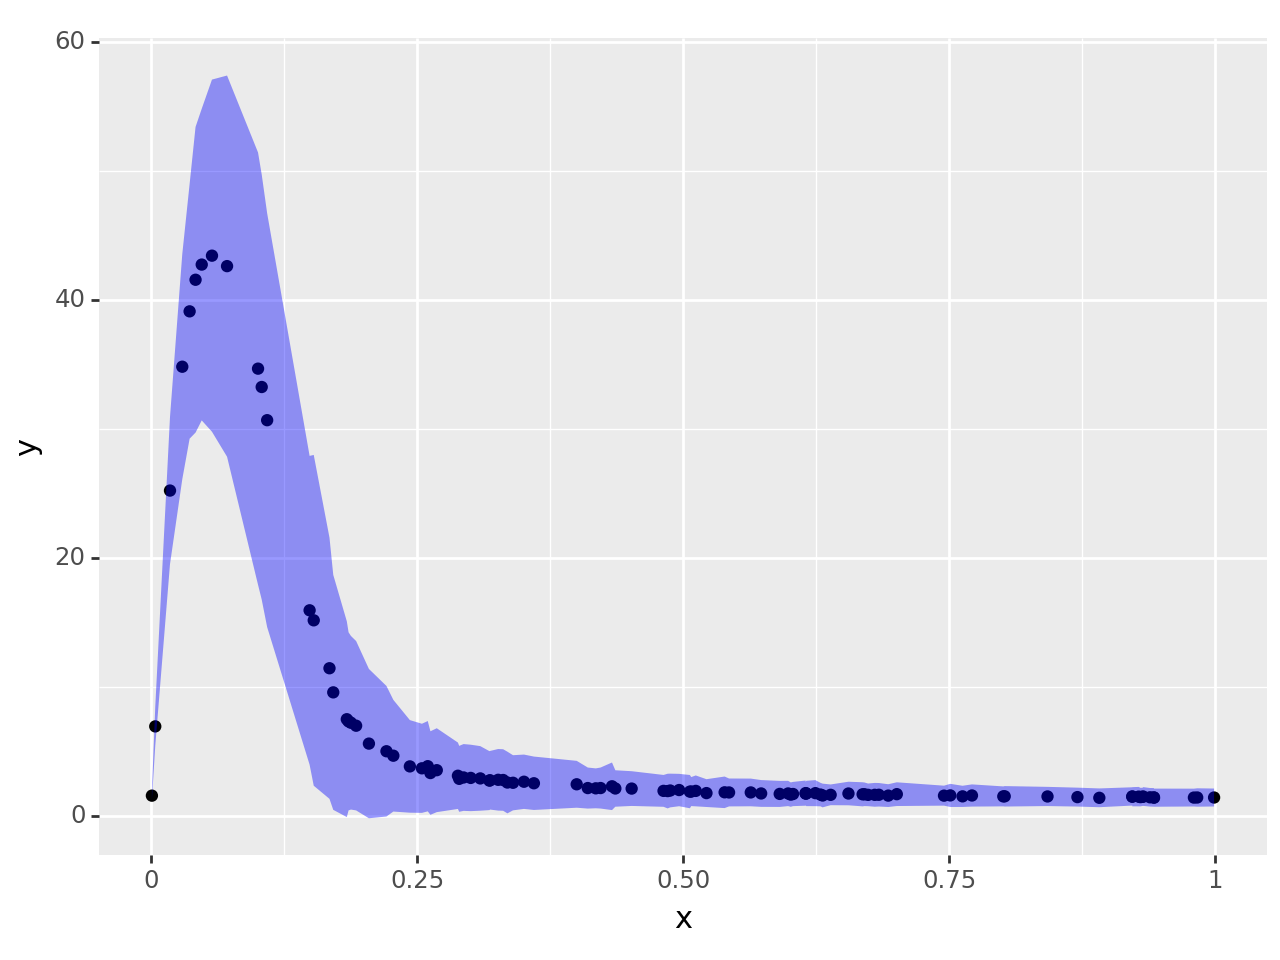

<Figure Size: (640 x 480)>

In [68]:
df = pl.from_records(results, schema=["x", "y", "ymin", "ymax"])

from plotnine import ggplot, aes, geom_point, geom_ribbon

ggplot(df, aes("x", "y", ymin = "ymin", ymax = "ymax")) + geom_point() + geom_ribbon(alpha=0.4, fill="blue")

## Const Esc

100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


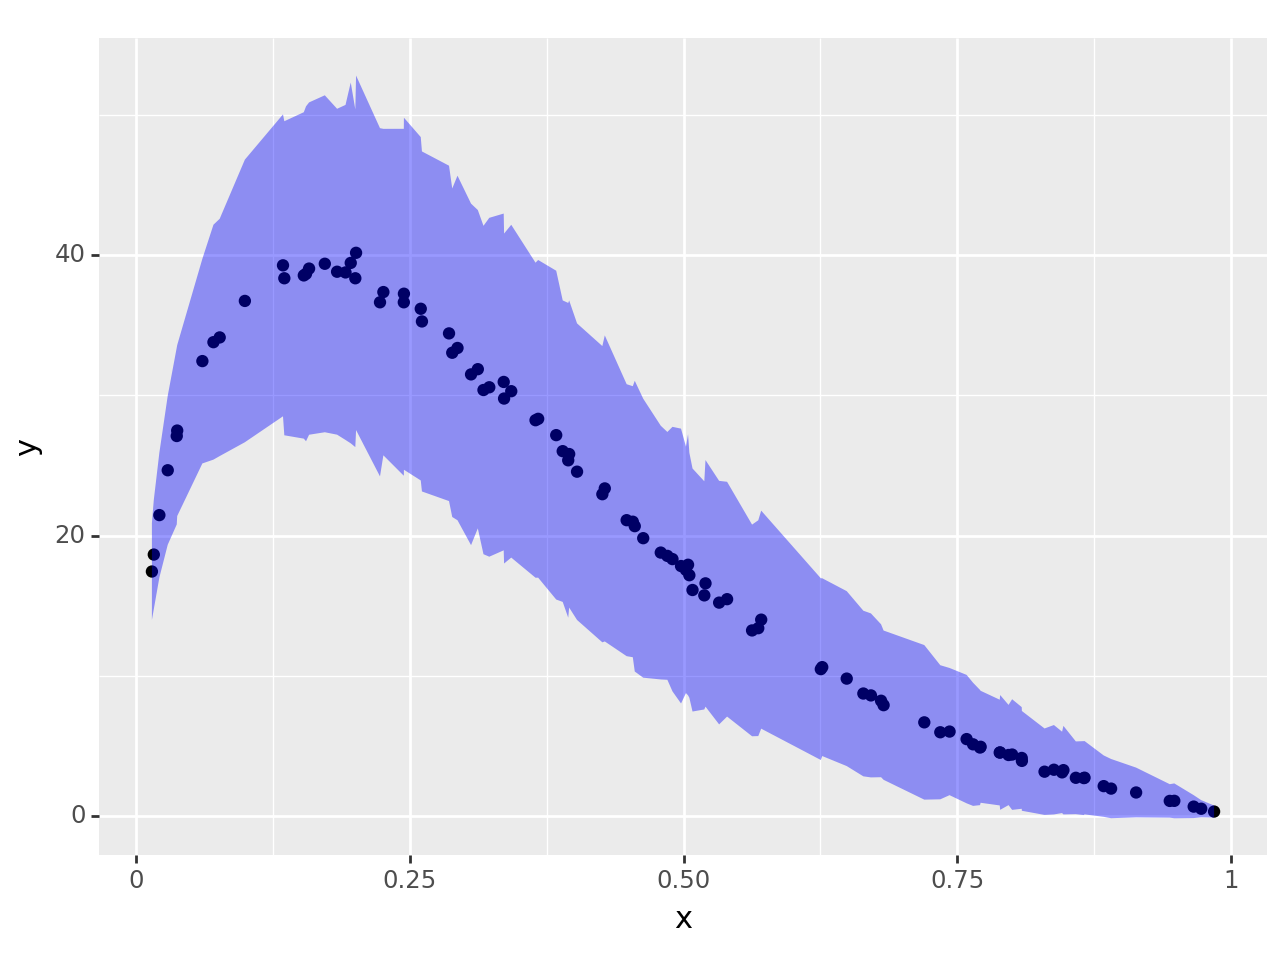

<Figure Size: (640 x 480)>

In [72]:
results = []
for _ in tqdm(range(100)):
    x = np.random.rand()
    manager = ConstEsc(escapement=x)
    results.append([x, *gather_stats(manager, env=env)])

df = pl.from_records(results, schema=["x", "y", "ymin", "ymax"])

from plotnine import ggplot, aes, geom_point, geom_ribbon

ggplot(df, aes("x", "y", ymin = "ymin", ymax = "ymax")) + geom_point() + geom_ribbon(alpha=0.4, fill="blue")

In [73]:
cesc_optimum_result = max(results, key= lambda r: r[1])
cesc_optimum_result

[0.200825496640462, 40.16737971515492, 27.523717947684048, 52.8110414826258]

## Cautionary Rule (MSY-bootstrapped)

In [56]:
results = []
y2 = opt_msy
for radius in np.linspace(0.01, 0.1, 21):
    print(radius)
    for _ in tqdm(range(100)):
        theta = np.random.rand() * np.pi / 4
        x1 = np.sin(theta) * radius
        x2 = np.cos(theta) * radius 
        # sin / cos are chosen so that x1 < x2
        manager = CautionaryRule(x1=x1, x2=x2, y2=y2)
        
        results.append([x1, x2, *gather_stats(manager, env=env)])

0.01


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


0.0145


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


0.019000000000000003


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


0.0235


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


0.028000000000000004


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


0.0325


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


0.037000000000000005


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


0.0415


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


0.046000000000000006


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


0.05050000000000001


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


0.05500000000000001


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


0.059500000000000004


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


0.064


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


0.0685


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


0.073


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


0.0775


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


0.082


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


0.08650000000000001


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


0.09100000000000001


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


0.0955


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


0.1


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


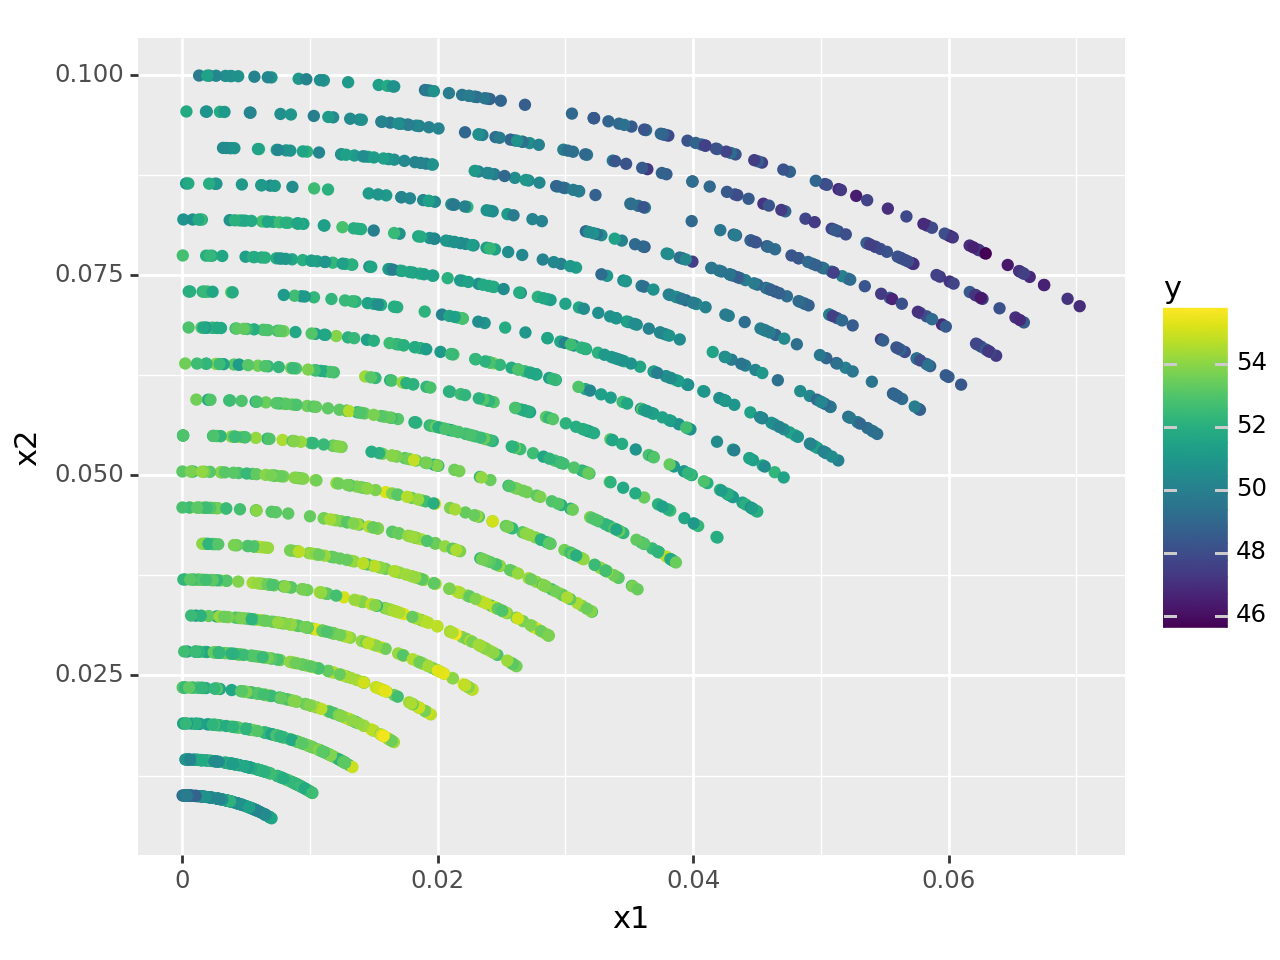

<Figure Size: (640 x 480)>

In [57]:
df = pl.from_records(results, schema=["x1", "x2", "y", "ymin", "ymax"])

from plotnine import ggplot, aes, geom_point

ggplot(df, aes("x1", "x2", color="y")) + geom_point() 

In [63]:
cr_optimum_result = max(results, key= lambda r: r[2])

In [74]:
cesc_optimum_result

[0.200825496640462, 40.16737971515492, 27.523717947684048, 52.8110414826258]

## Gathering best results

In [80]:
optima = {
    "msy" : {
        "opt_arg": msy_optimum_result[0],
        "mean_rew": msy_optimum_result[1],
        "low_rew": msy_optimum_result[2],
        "hi_rew": msy_optimum_result[3],
    },
    "cesc": {
        "opt_arg": cesc_optimum_result[0],
        "mean_rew": cesc_optimum_result[1],
        "low_rew": cesc_optimum_result[2],
        "hi_rew": cesc_optimum_result[3],
    },
    "cr": {
        "opt_arg": f"x1 = {cr_optimum_result[0]}, x2 = {cr_optimum_result[1]}",
        "mean_rew": cr_optimum_result[2],
        "low_rew": cr_optimum_result[3],
        "hi_rew": cr_optimum_result[4],
    }
}
import json

print(json.dumps(optima, indent=2))

{
  "msy": {
    "opt_arg": 0.057281475010678484,
    "mean_rew": 43.431823904527775,
    "low_rew": 29.77316938627395,
    "hi_rew": 57.0904784227816
  },
  "cesc": {
    "opt_arg": 0.200825496640462,
    "mean_rew": 40.16737971515492,
    "low_rew": 27.523717947684048,
    "hi_rew": 52.8110414826258
  },
  "cr": {
    "opt_arg": "x1 = 0.015925028340586737, x2 = 0.02303027295434228",
    "mean_rew": 55.508004457912584,
    "low_rew": 41.701449449441164,
    "hi_rew": 69.314559466384
  }
}


## MSY grid search

In [8]:
import ray

@ray.remote
def ff(x):
    return f(x)

# formulate as matrix of values
effort = np.linspace(0,.25,501)
data = [ff.remote(i) for i in effort]
data = ray.get(data)


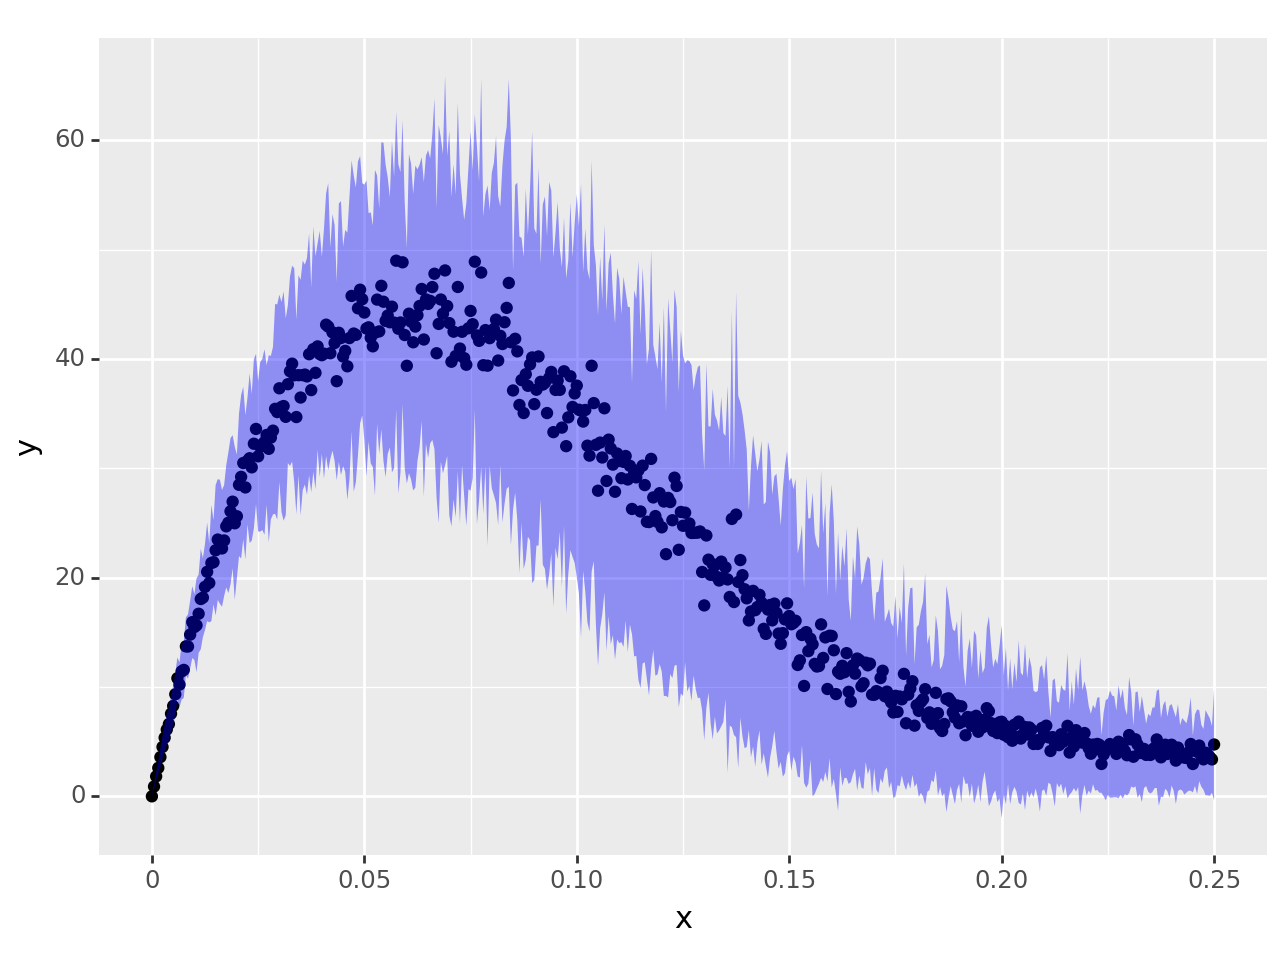

<Figure Size: (640 x 480)>

In [9]:
df = pl.from_records(data, schema=["x", "y", "ymin", "ymax"])


from plotnine import ggplot, aes, geom_point, geom_ribbon

ggplot(df, aes("x", "y", ymin = "ymin", ymax = "ymax")) + geom_point() + geom_ribbon(alpha=0.4, fill="blue")

In [63]:
def g(x):
    out = f(x[0])
    return - out[1]

In [ ]:
from skopt import gp_minimize
res = gp_minimize(g, [(0.02, 0.2)], n_calls = 100)
res.x

In [ ]:
from skopt import gbrt_minimize
res2 = gbrt_minimize(g, [(0.02, 0.15)], n_calls = 100)
res2.x